In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np


In [2]:

import plotly.express as px

In [3]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

In [4]:
# аналогичным образом загружаем данные о пассажирах
df = pd.read_csv('data/Annual precipitation inches Lake Huron 1900 to 1986.csv')

In [5]:
df.head()

,Time,x
0,1,31.42
1,2,30.28
2,3,33.21
3,4,33.98
4,5,31.07


## Предсказание временного ряда с помощью деревьев

Попробуем обычное дерево решений и случайный лес, а потом сравним результаты

In [6]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from numpy import asarray

In [7]:
n_vars = 1 if type(df) is list else df.shape[1]
cols = list()
for i in range(1, 0, -1):
    cols.append(df.shift(i))
for i in range(0, 1):
    cols.append(df.shift(-i))
# put it all together
agg = pd.concat(cols, axis=1)
agg.dropna(inplace=True)
list_for_forecast = agg.values

In [8]:
len(list_for_forecast)

86

In [9]:
def decision_tree_forecast(train, testX):
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = DecisionTreeRegressor(random_state=0)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]

In [10]:
def random_forest_forecast(train, testX):
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]

In [11]:
predictions = list()
size = int(len(list_for_forecast) * 0.66)
train, test = list_for_forecast[0:size], list_for_forecast[size:len(list_for_forecast)]
history = [x for x in train]

for i in range(len(test)):
    testX, testy = test[i, :-1], test[i, -1]
    yhat = random_forest_forecast(history, testX)
    predictions.append(yhat)
    history.append(test[i])

error = mean_absolute_error(test[:, -1], predictions)
print("Random Forest error: ", error)

Random Forest error:  3.2771696666667176


In [12]:
print("Random Forest metrics: ")
print("RMSE:", np.sqrt(mean_squared_error(test[:, -1], predictions)))
print("MAPE:", mean_absolute_percentage_error(test[:, -1], predictions))
print("MAE:", mean_absolute_error(test[:, -1], predictions))
print("R2: ", r2_score(test[:, -1], predictions))

Random Forest metrics: 
RMSE: 4.015222187917327
MAPE: 0.10038148174423098
MAE: 3.2771696666667176
R2:  -0.27017332129205185


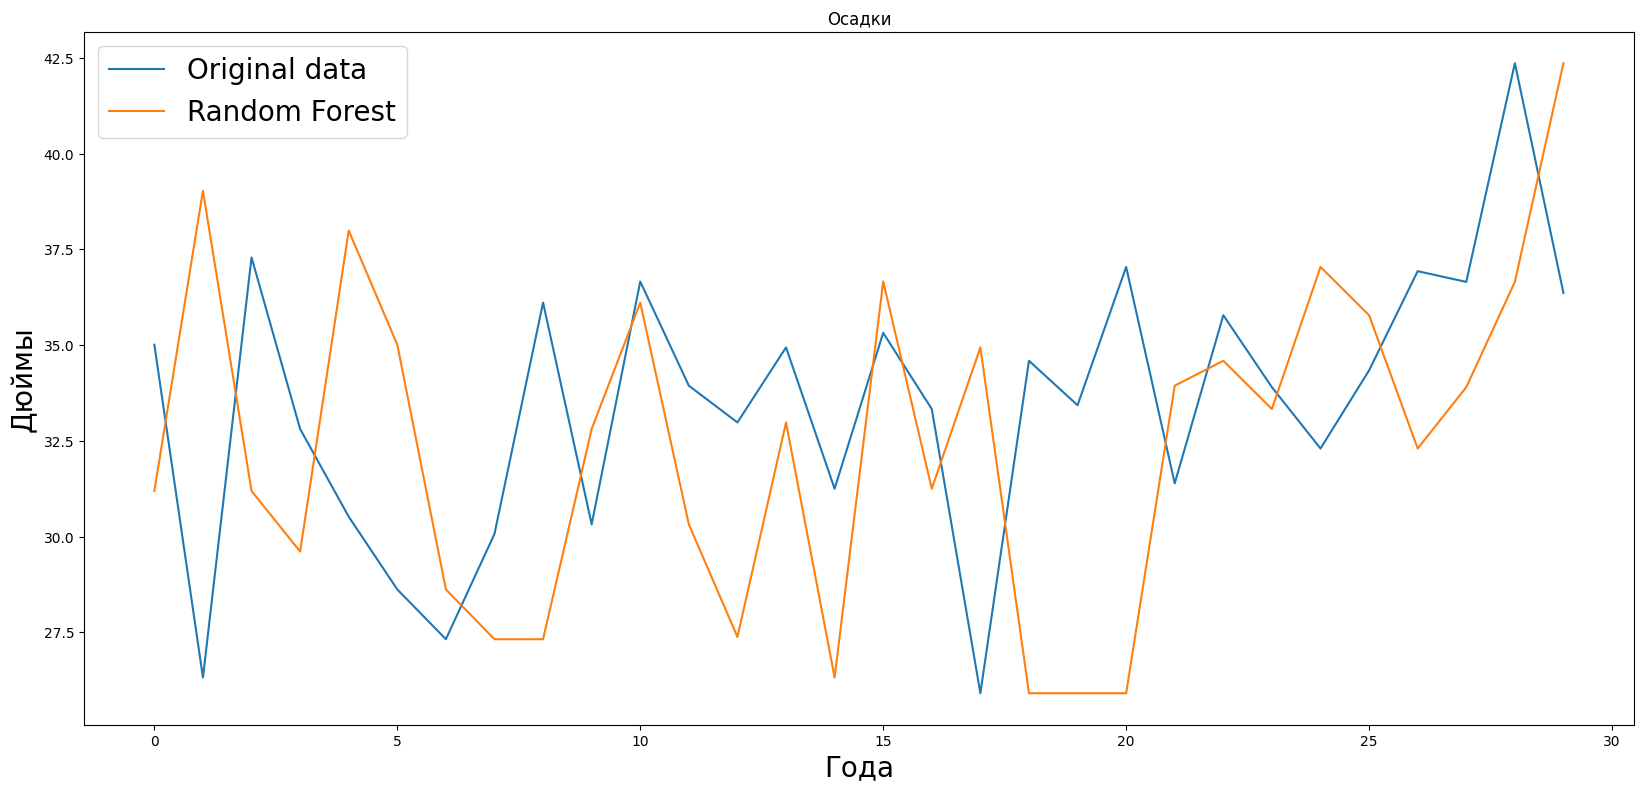

In [24]:
fig = plt.figure(figsize=(20, 9))
plt.plot(test[:, -1], label='Original data')
plt.plot(predictions, label='Random Forest')
plt.legend(fontsize="20")
plt.title('Осадки')
plt.ylabel('Дюймы', fontsize="20")
plt.xlabel('Года', fontsize="20")
plt.show()

In [14]:
predictions = list()
size = int(len(list_for_forecast) * 0.66)
train, test = list_for_forecast[0:size], list_for_forecast[size:len(list_for_forecast)]
history = [x for x in train]

for i in range(len(test)):
    testX, testy = test[i, :-1], test[i, -1]
    yhat = decision_tree_forecast(history, testX)
    predictions.append(yhat)
    history.append(test[i])


In [15]:
print("Decision Forest metrics: ")
print("RMSE:", np.sqrt(mean_squared_error(test[:, -1], predictions)))
print("MAPE:", mean_absolute_percentage_error(test[:, -1], predictions))
print("MAE:", mean_absolute_error(test[:, -1], predictions))
print("R2: ", r2_score(test[:, -1], predictions))

Decision Forest metrics: 
RMSE: 5.6558830728130625
MAPE: 0.14455008088127402
MAE: 4.701333333333333
R2:  -1.5202560524667827


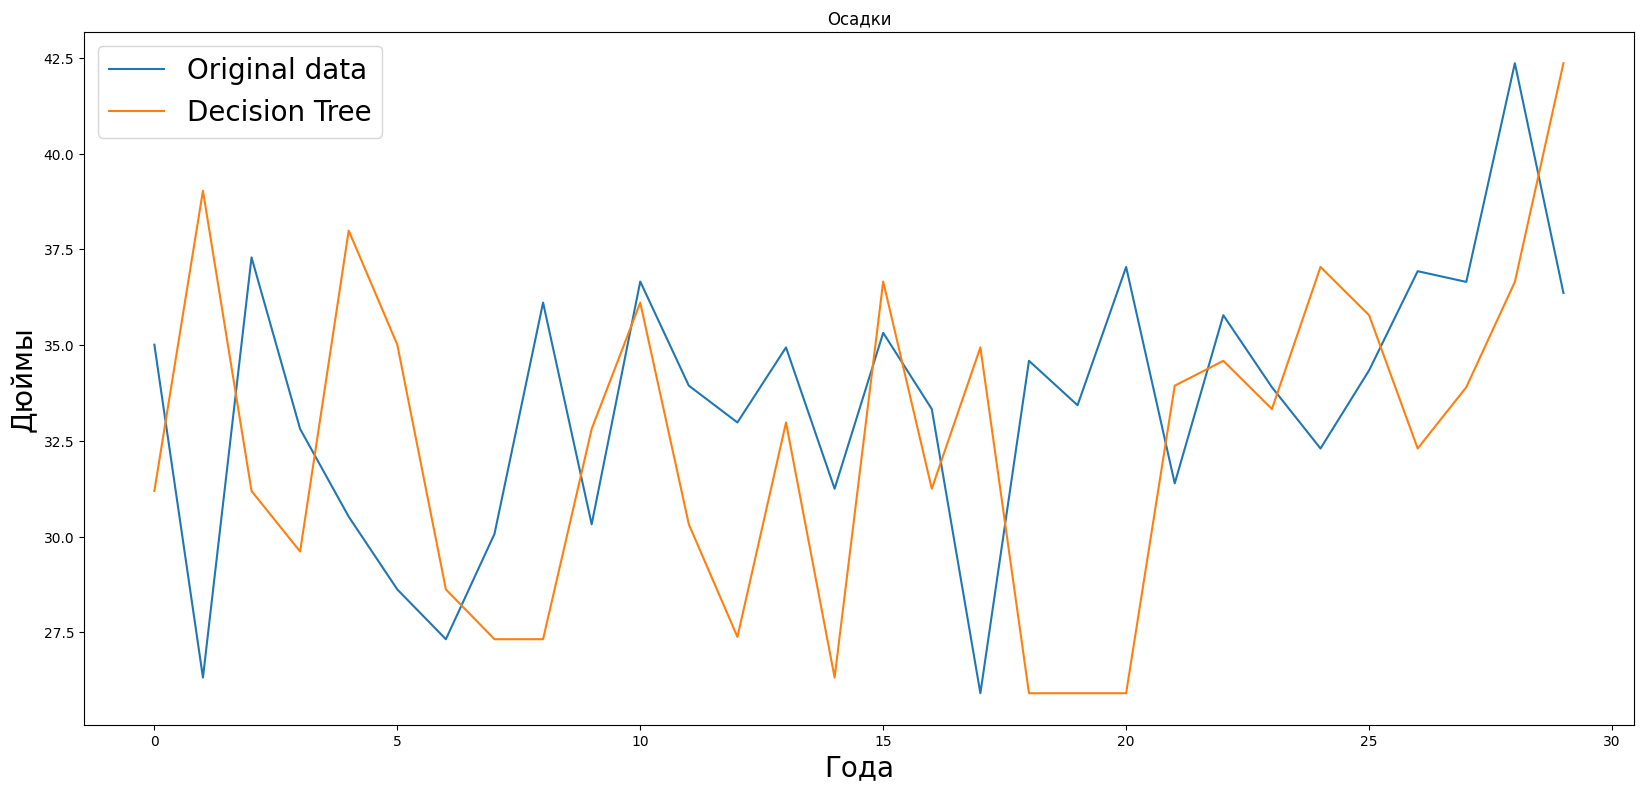

In [23]:
fig = plt.figure(figsize=(20, 9))
plt.plot(test[:, -1], label='Original data')
plt.plot(predictions, label='Decision Tree')
plt.legend(fontsize="20")
plt.title('Осадки')
plt.ylabel('Дюймы', fontsize="20")
plt.xlabel('Года', fontsize="20")
plt.show()

## Детекция аномалий с помощью isolated forest

In [17]:
from sklearn.ensemble import IsolationForest

In [18]:
# аналогичным образом загружаем данные о пассажирах
df2 = pd.read_csv('data/Annual precipitation inches Lake Huron 1900 to 1986.csv')

In [19]:
model = IsolationForest(contamination=0.004)
model.fit(df2[['x']])

IsolationForest(contamination=0.004)

In [20]:
df2['outliers'] = pd.Series(model.predict(df2[['x']])).apply(lambda x: 'yes' if (x == -1) else 'no' )

In [21]:
df2.query('outliers=="yes"')

,Time,x,outliers
85,86,42.36,yes


In [22]:
fig = px.scatter(df2.reset_index(), x='Time', y='x', color='outliers')
fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()